In [66]:
import os
print(os.getcwd())
import sys
print(sys.executable)

/home/sharedgroup
/home/sharedgroup/anaconda3/envs/tf_gpu_3.9/bin/python3


In [67]:
import os
import tensorflow as tf
import cv2
import numpy as np

from PIL import Image
from sklearn.model_selection import train_test_split


In [68]:
from tensorflow.keras import mixed_precision

policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

In [69]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


2023-05-23 18:27:03.545774: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-05-23 18:27:03.549575: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-23 18:27:03.550742: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:07.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2023-05-23 18:27:03.550982: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-05-23 18:27:03.551347: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-05-23 18:27:03.551388: I tensorflow/stream_executor/plat

### Loading JPEG images and their masks
We create a general import function.

In [79]:
def image_importer(directory: str, filetype: str):
    """
    Imports images from a given directory and ensures them to be of size (1080, 1920, 3).
    :param directory: The path to the directory
    :return: list of all images
    """
    image_list = []
    for i in range(1, len(os.listdir(directory))+1):
        file = f'Amateur{i}.{filetype}'
        image = cv2.imread(os.path.join(directory, file))

        # Resize to (1080, 1920, 3) if not this size.
        height, width, channels = image.shape
        if width < 1920:
            image = cv2.resize(image, (1920, 1080), interpolation=cv2.INTER_LINEAR)
        image_list.append(image)

    return image_list

Load in the images

In [80]:
jpeg_directory = './datasets/output/JPEGImages'
jpeg_images = image_importer(jpeg_directory, 'jpg')

mask_directory = './datasets/output/SegmentationClassPNG'
mask_images = image_importer(mask_directory, 'png')

Check if the JPEG and mask images looks good

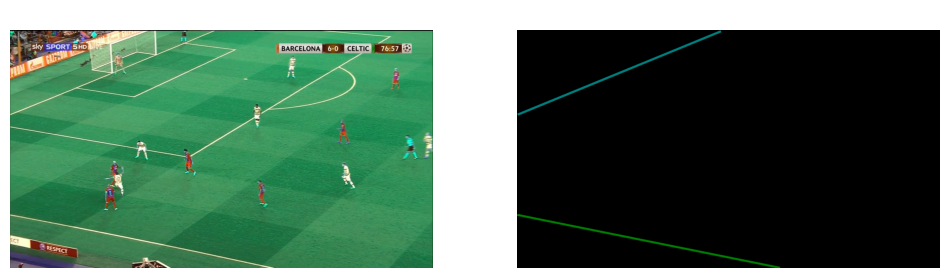

In [81]:
from matplotlib import pyplot as plt
import random

plt.figure(figsize=(12, 6))

image_number = random.randint(0, len(jpeg_images)-1)
plt.subplot(121)
plt.imshow(jpeg_images[image_number])
plt.axis("off")
plt.title("Image", color = "white")

plt.subplot(122)
plt.imshow(mask_images[image_number])
plt.axis("off")
plt.title("Mask", color = "white")
plt.show()

Load the labels

In [82]:
# Load the label data from npy file
labels_directory = './datasets/output/SegmentationClass'
labels_list = []

for i in range(1, len(os.listdir(labels_directory)) + 1):
    file = f'Amateur{i}.npy'
    label = np.load(os.path.join(labels_directory, file))

    # Append to label if the width is not 1920
    if label.shape[1] != 1920:
        padding_width = 1920 - label.shape[1]
        label = np.pad(label, ((0, 0), (0, padding_width)), 'constant')
    labels_list.append(label)

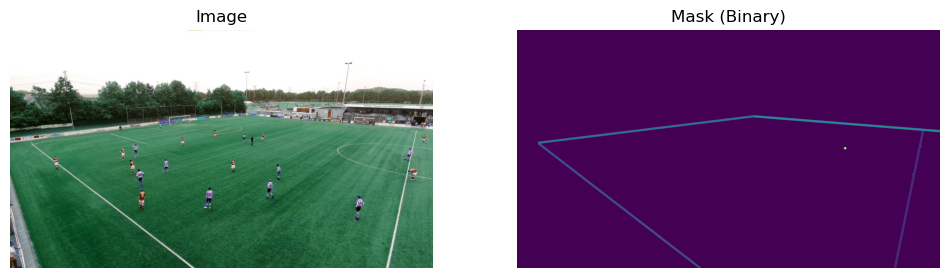

In [83]:
from matplotlib import pyplot as plt
import random

plt.figure(figsize=(12, 6))

image_number = random.randint(0, len(jpeg_images)-1)
plt.subplot(121)
plt.imshow(jpeg_images[image_number])
plt.axis("off")
plt.title("Image")

plt.subplot(122)
plt.imshow(labels_list[image_number])
plt.axis("off")
plt.title("Mask (Binary)")
plt.show()

### Prepare for unet (conversion to np.array and train test split)

In [84]:
jpeg_images = np.array(jpeg_images)
mask_images = np.array(mask_images)
labels_list = np.array(labels_list)

Train-test split

In [86]:
labels_list = np.where(labels_list > 1, 1, labels_list)
labels_list = np.expand_dims(labels_list, axis=-1)

X_train, X_val, y_train, y_val = train_test_split(
    jpeg_images, labels_list,
    test_size=0.2, random_state=0
)

In [89]:
del jpeg_images,mask_images, labels_list

### Data Augmentation

In [90]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_datagen = ImageDataGenerator(horizontal_flip=True,
                             brightness_range=[0.8,1.2],
                             zoom_range=[.7,1.],
                             fill_mode='nearest')

mask_datagen = ImageDataGenerator(horizontal_flip=True,
                             # brightness_range=[0.15,1.3],
                             zoom_range=[.7,1.],
                             fill_mode='nearest')

In [91]:
seed = 1
batch_size=8

image_gen = image_datagen.flow(X_train, seed=seed, batch_size=batch_size)
mask_gen = mask_datagen.flow(y_train, seed=seed, batch_size=batch_size)

float32
float32
199065600
66355200


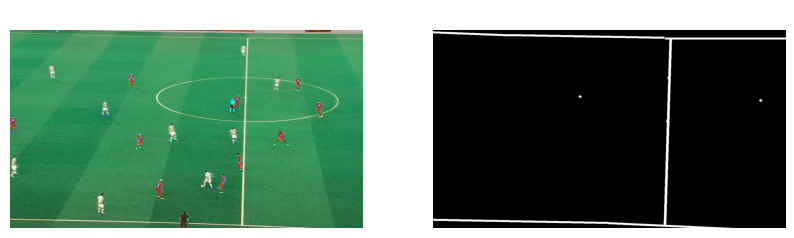

In [93]:
x = image_gen.next()
y = mask_gen.next()

for i in range(1):
    image = x[i]
    mask = y[i]

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(image.astype('uint8'))
    axs[0].set_title('Augmented Image', color='white')
    axs[0].axis('off')

    axs[1].imshow(mask.squeeze(), cmap='gray')
    axs[1].set_title('Augmented Mask', color='white')
    axs[1].axis('off')

    plt.show()


### Testing Data Augmentation

In [94]:
# datagen = ImageDataGenerator(horizontal_flip=True,
#                              brightness_range=[0.15,1.3],
#                              zoom_range=[0.5,1.5],
#                              )
# train_generator = datagen.flow(X_train, batch_size=1)
# rows = 3
# columns = 3
# fig, axes = plt.subplots(rows,columns)
# for r in range(rows):
#     for c in range(columns):
#         image_batch = train_generator.next()
#         image = image_batch[0].astype('uint8')
#         axes[r,c].imshow(image)
# fig.set_size_inches(15,10)

Mask Generation

In [95]:
def image_mask_generator(image_gen, mask_gen,dtype = np.float16):
    train_gen = zip(image_gen, mask_gen)
    for (img, mask) in train_gen:
        yield (img.astype(dtype), mask.astype(dtype))

my_generator = image_mask_generator(image_gen, mask_gen)

### U-Net Architecture

In [96]:
def convolutional_part(input, n_filters):
    """
    Creates the convolutional part of the U-Net. Returns the "copied_output" which is copied to the symmetrical side of
    the U-Net
    """

    # 1st layer
    copied_output = Conv2D(n_filters, (3,3), padding="same", activation= "relu")(input)
    # copied_output = BatchNormalization()(copied_output)
    # 2nd layer
    copied_output = Conv2D(n_filters, (3,3), padding="same", activation="relu")(copied_output)
    # copied_output = BatchNormalization()(copied_output)

    return copied_output

In [97]:
from tensorflow.keras.layers import MaxPool2D


def contraction_block(input, n_filters):
    """
    Creates the contraction part of the U-Net. Returns the "copied_output" which is copied to the symmetrical side of
    the U-Net and "max_pooling_output" which is the output of max pooling operation downsampling in the U-Net.
    """

    copied_output = convolutional_part(input, n_filters)
    max_pooling_output = MaxPool2D((2,2), strides=2)(copied_output)

    return copied_output, max_pooling_output

In [98]:
from tensorflow.keras.layers import Conv2DTranspose, Concatenate


def expansion_block(input, skip_connections , n_filters):
    """
    Creates the expansion part of the U-Net. Returns the "expansion_output" which is the output of upsampling operation
    in the U-Net.
    """
    expansion_output = Conv2DTranspose(n_filters, (2, 2), strides=2, padding="same")(input)
    expansion_output = Concatenate()([expansion_output, skip_connections])
    expansion_output = convolutional_part(expansion_output, n_filters)

    return expansion_output

In [99]:
from tensorflow.keras.layers import Conv2D
from tensorflow.keras import Model, Input


def build_unet(input_shape, number_output_classes):
    """ Building U-Net using the functions above. "s" stands for skipped connection, "cl" stands for contraction level,
     "b" stands for bridge, "el" stands for expansion level.
    """

    inputs = Input(input_shape)

    # Down sampling
    s1, cl1 = contraction_block(inputs, 16)
    s2, cl2 = contraction_block(cl1, 32)
    s3, cl3 = contraction_block(cl2, 64)
    # s4, cl4 = contraction_block(cl3, 512)

    # Bridge
    b1 = convolutional_part(cl3, 128)

    # Up sampling
    # el1 = expansion_block(b1, s4, 512)
    el2 = expansion_block(b1, s3, 64)
    el3 = expansion_block(el2, s2, 32)
    el4 = expansion_block(el3, s1, 16)

    outputs = Conv2D(number_output_classes, (1,1), padding="same", activation="sigmoid")(el4)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [100]:
import tensorflow as tf
from tensorflow.keras import backend as K

def weighted_binary_crossentropy(y_true, y_pred):
    # Define weights
    weight_for_0 = tf.constant(1.0, dtype=tf.float32)  # for 'not a line'
    weight_for_1 = tf.constant(20.0, dtype=tf.float32)  # for 'line' (10 times more important)

    # Cast y_true and y_pred to the correct type (float32)
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    # Calculate the binary crossentropy
    b_ce = K.binary_crossentropy(y_true, y_pred)

    # Apply the weights
    weight_vector = y_true * weight_for_1 + (1. - y_true) * weight_for_0
    weighted_b_ce = weight_vector * b_ce

    # Return the mean error
    return K.mean(weighted_b_ce)

In [101]:
from tensorflow.keras.optimizers import Adam

input = (X_train[0].shape[0],X_train[0].shape[1],X_train[0].shape[2])
number_output_classes = 1

model=build_unet(input,number_output_classes)
model.compile(optimizer=Adam(learning_rate = 1e-5), loss=weighted_binary_crossentropy, metrics=['accuracy'])
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1080, 1920,  0                                            
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, 1080, 1920, 1 448         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_31 (Conv2D)              (None, 1080, 1920, 1 2320        conv2d_30[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 540, 960, 16) 0           conv2d_31[0][0]                  
______________________________________________________________________________________________

In [102]:
# from tensorflow.keras.utils import plot_model
# plot_model(model)

In [103]:
batch_size = 8
epochs = 1000
steps_per_epoch = 10

In [104]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
checkpoint_filepath = 'best_model.h5'

earlystopping = EarlyStopping(monitor='val_loss', patience=6, min_delta = 0.01)

model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, save_best_only=True,
                                   monitor='val_loss', mode='min')

In [105]:
history = model.fit(my_generator, batch_size=batch_size, epochs=epochs,
                    steps_per_epoch=steps_per_epoch, 
                    validation_data=(X_val, y_val),
                    callbacks=[earlystopping, model_checkpoint])

Epoch 1/1000
10/10 [==============================] - 43s 4s/step - loss: 14.0168 - accuracy: 0.0126 - val_loss: 14.2313 - val_accuracy: 0.0141
Epoch 2/1000
10/10 [==============================] - 45s 5s/step - loss: 14.1406 - accuracy: 0.0125 - val_loss: 14.0458 - val_accuracy: 0.0143
Epoch 3/1000
10/10 [==============================] - 47s 5s/step - loss: 13.7098 - accuracy: 0.0122 - val_loss: 13.5695 - val_accuracy: 0.0146
Epoch 4/1000
10/10 [==============================] - 46s 5s/step - loss: 13.3390 - accuracy: 0.0126 - val_loss: 12.3458 - val_accuracy: 0.0152
Epoch 5/1000
10/10 [==============================] - 47s 5s/step - loss: 10.7858 - accuracy: 0.0136 - val_loss: 8.7671 - val_accuracy: 0.0166
Epoch 6/1000
10/10 [==============================] - 44s 4s/step - loss: 8.2270 - accuracy: 0.0142 - val_loss: 5.8871 - val_accuracy: 0.0211
Epoch 7/1000
10/10 [==============================] - 45s 5s/step - loss: 4.9087 - accuracy: 0.0187 - val_loss: 3.6770 - val_accuracy: 0.05

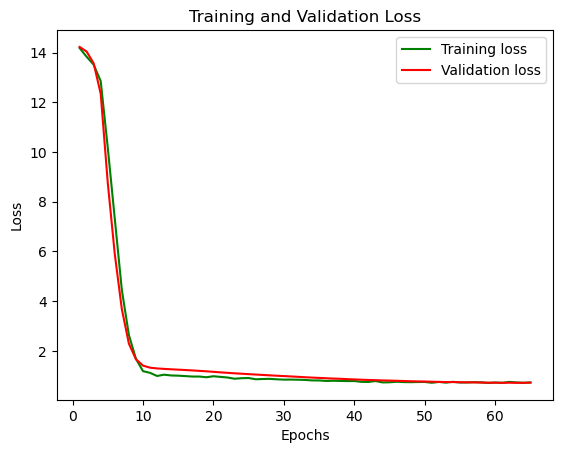

In [106]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

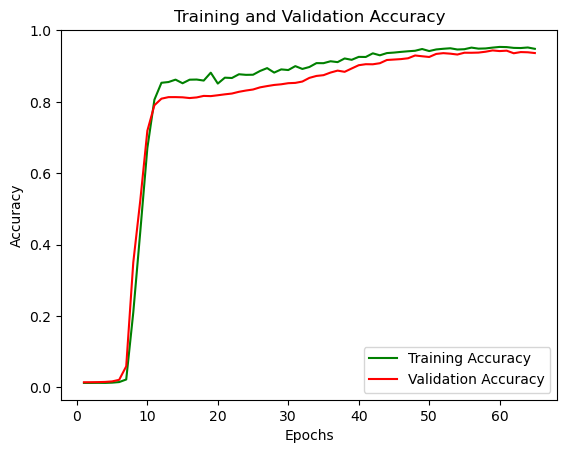

In [107]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']


epochs = range(1, len(train_acc) + 1)

# Plot training and validation accuracy
plt.plot(epochs, train_acc, 'g', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Trial

In [108]:
from sklearn.metrics import log_loss

In [109]:
loaded_model=build_unet(input,number_output_classes)
loaded_model.compile(optimizer=Adam(learning_rate = 1e-5), loss=weighted_binary_crossentropy, metrics=['accuracy'])

loaded_model.load_weights('best_model.h5')
print(np.shape(X_val))
print(np.shape(y_val))

(22, 1080, 1920, 3)
(22, 1080, 1920, 1)


In [110]:
# Choose a single image from the validation or test set
number = 9
image = X_val[number:number+1,:,:,:]
print(np.shape(image))
ground_truth_mask = y_val[number:number+1,:,:,:]

# Reshape the image if necessary
#image = np.reshape(image, (1,) + image.shape)

# Make prediction on the image
prediction = loaded_model.predict(image)

print(ground_truth_mask)
print(prediction)

flattened_ground_truth = ground_truth_mask.flatten()
flattened_prediction = prediction.flatten()
print(log_loss(flattened_ground_truth, flattened_prediction))
# Post-process the prediction and ground truth masks
threshold = 0.5
prediction_binary = np.where(prediction > threshold, 1, 0)
# print(prediction_binary)
# ground_truth_binary = np.where(ground_truth_mask > threshold, 1, 0)

(1, 1080, 1920, 3)
[[[[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  ...

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]]]
[[[[5.601e-01]
   [6.519e-01]
   [4.966e-01]
   ...
   [5.483e-01]
   [4.531e-01]
   [4.932e-01]]

  [[3.452e-01]
   [6.392e-01]
   [2.896e-01]
   ...
   [2.429e-01]
   [5.679e-01]
   [4.070e-01]]

  [[2.144e-01]
   [2.922e-01]
   [1.710e-01]
   ...
   [2.097e-01]
   [3.098e-01]
   [2.776e-01]]

  ...

  [[2.106e-01]
   [6.340e-03]
   [3.315e-01]
   ...
   [9.829e-01]
   [1.000e+00]
   [1.000e+00]]

  [[8.389e-01]
   [1.810e-02]
   [6.390e-03]
   ...
   [1.064e-04]
   [8.218e-01]
   [1.687e-01]]

  [[9.873e-01]
   [9.590e-01]
   [9.482e-01]
   ...
   [9.951e-01]
   [1.000e+00]
   [9.863e-01]]]]
0.2469358045194126


In [111]:
non_zeros_count = np.count_nonzero(prediction_binary)
print(f"ratio of non-zero: {non_zeros_count/prediction_binary.size}")

ratio of non-zero: 0.04381847993827161


ratio of non-zero: 0.019782986111111112


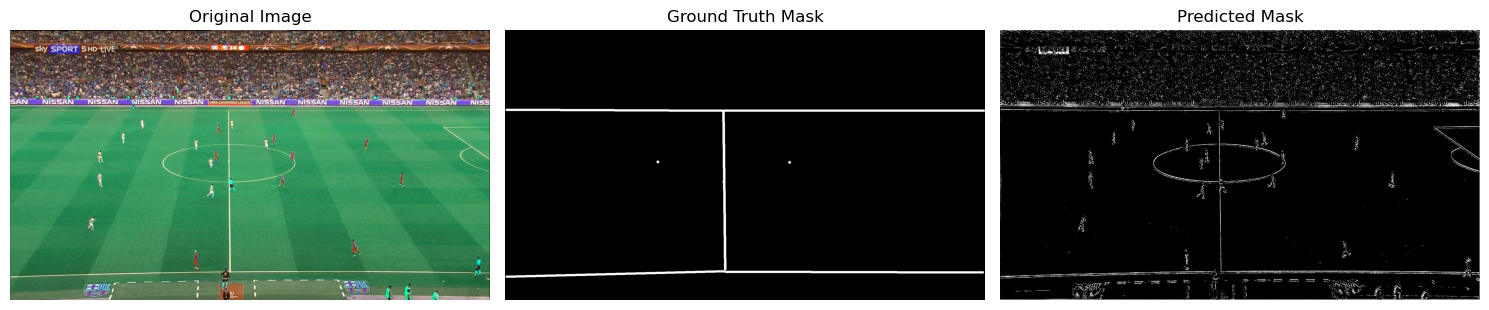

In [113]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))  # Increase figure size for better visibility

plt.subplot(1, 3, 1)
plt.imshow(image.squeeze(), cmap='gray')
plt.axis("off")
plt.title("Original Image")

plt.subplot(1, 3, 2)
plt.imshow(ground_truth_mask.squeeze(), cmap='gray')
plt.axis("off")
plt.title("Ground Truth Mask")

non_zeros_count = np.count_nonzero(ground_truth_mask)
print(f"ratio of non-zero: {non_zeros_count/ground_truth_mask.size}")

plt.subplot(1, 3, 3)
img = plt.imshow(prediction_binary.squeeze(), cmap='gray')
plt.axis("off")
plt.title("Predicted Mask")

# plt.colorbar(img, ax=plt.gca())  # Add colorbar for the last image

plt.tight_layout()
plt.show()


### Metrics

IoU / Pixel Accuracy Score 

In [114]:
y_pred=loaded_model.predict(X_val)
threshold=0.5
y_pred_binary = np.where(y_pred > threshold, 1, 0)


In [115]:
def evaluate_masks(predicted_masks, ground_truth_masks):
    iou_scores = []
    dice_scores = []
    pixel_accuracy = []

    for i in range(len(predicted_masks)):
        pred_mask = predicted_masks[i]
        gt_mask = ground_truth_masks[i]

        intersection = np.logical_and(pred_mask, gt_mask)
        union = np.logical_or(pred_mask, gt_mask)

        iou = np.sum(intersection) / np.sum(union)
        dice = (2.0 * np.sum(intersection)) / (np.sum(pred_mask) + np.sum(gt_mask))
        accuracy = np.mean(pred_mask == gt_mask)

        iou_scores.append(iou)
        dice_scores.append(dice)
        pixel_accuracy.append(accuracy)

    mean_iou = np.mean(iou_scores)
    mean_dice_scores = np.mean(dice_scores)
    mean_pixel_accuracy = np.mean(pixel_accuracy)
    
    print("Mean IoU:", mean_iou)
    print("Mean Dice Scores:", mean_dice_scores)
    print("Mean Pixel Accuracy:", mean_pixel_accuracy)

In [116]:
evaluate_masks(y_pred_binary, y_val)

Mean IoU: 0.037364431433543774
Mean Dice Scores: 0.07129709823169578
Mean Pixel Accuracy: 0.9433578843995511


In [117]:
from sklearn.metrics import confusion_matrix

def compute_fpr_fnr(y_pred, ground_truth_masks):
    num_masks = len(y_pred)
    all_y_pred = np.concatenate(y_pred)
    all_ground_truth = np.concatenate(ground_truth_masks)
    
    cm = confusion_matrix(all_ground_truth.flatten(), all_y_pred.flatten())
    tn, fp, fn, tp = cm.ravel()
    
    fpr = fp / (fp + tn)
    fnr = fn / (fn + tp)
    
    print("False Positive Rate (FPR):", fpr)
    print("False Negative Rate (FNR):", fnr)


In [118]:
compute_fpr_fnr(y_pred_binary, y_val)

False Positive Rate (FPR): 0.045871871135618476
False Negative Rate (FNR): 0.8423863175812596
